The objective of this project is to build a breast cancer classifier on an IDC dataset that can accurately classify a histology image as benign or malignant.

In this project  python, we’ll build a classifier to train on 80% of a breast cancer histology image dataset. Of this, we’ll keep 10% of the data for validation. Using Keras, we’ll define a CNN (Convolutional Neural Network), call it CancerNet, and train it on our images. We’ll then derive a confusion matrix to analyze the performance of the model.

IDC is Invasive Ductal Carcinoma; cancer that develops in a milk duct and invades the fibrous or fatty breast tissue outside the duct; it is the most common form of breast cancer forming 80% of all breast cancer diagnoses. And histology is the study of the microscopic structure of tissues.

We’ll use the IDC_regular dataset (the breast cancer histology image dataset) from Kaggle. This dataset holds 2,77,524 patches of size 50×50 extracted from 162 whole mount slide images of breast cancer specimens scanned at 40x. Of these, 1,98,738 test negative and 78,786 test positive with IDC. The dataset is available in public domain and you can download it here: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images. You’ll need a minimum of 3.02GB of disk space for this.

Filenames in this dataset look like this:               8863_idx5_x451_y1451_class0.
Here, 8863_idx5 is the patient ID, 451 and 1451 are the x- and y- coordinates of the crop, and 0 is the class label (0 denotes absence of IDC).

In [1]:

import numpy as np
import glob
import random
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt
from glob import glob

from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm


import tensorflow as tf

random.seed(98)
np.random.seed(98)

In [2]:
breast_img = glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png


In [3]:
non_img = []
can_img = []

for img in breast_img:
    if img[-5] == '0' :
        non_img.append(img)
    
    elif img[-5] == '1' :
        can_img.append(img)

In [4]:
non_num = len(non_img)
can_num = len(can_img)
        
total_img_num = non_num + can_num
        
print('Number of Images in IDC (-): {}' .format(non_num))
print('Number of Images in IDC (+) : {}' .format(can_num))
print('Total Number of Images : {}' .format(total_img_num))

Number of Images in IDC (-): 198738
Number of Images in IDC (+) : 78786
Total Number of Images : 277524


In [5]:
from os import listdir
base_path = "/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)
print(total_images)

277524


In [6]:
import pandas as pd
data = pd.DataFrame(index=np.arange(0, total_img_num), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

patient_id                                               path target
0      10295  /kaggle/input/breast-histopathology-images/IDC...      0
1      10295  /kaggle/input/breast-histopathology-images/IDC...      0
2      10295  /kaggle/input/breast-histopathology-images/IDC...      0
3      10295  /kaggle/input/breast-histopathology-images/IDC...      0
4      10295  /kaggle/input/breast-histopathology-images/IDC...      0

In [7]:
data.shape

(277524, 3)

In [8]:
data.target = data.target.astype(np.int)
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

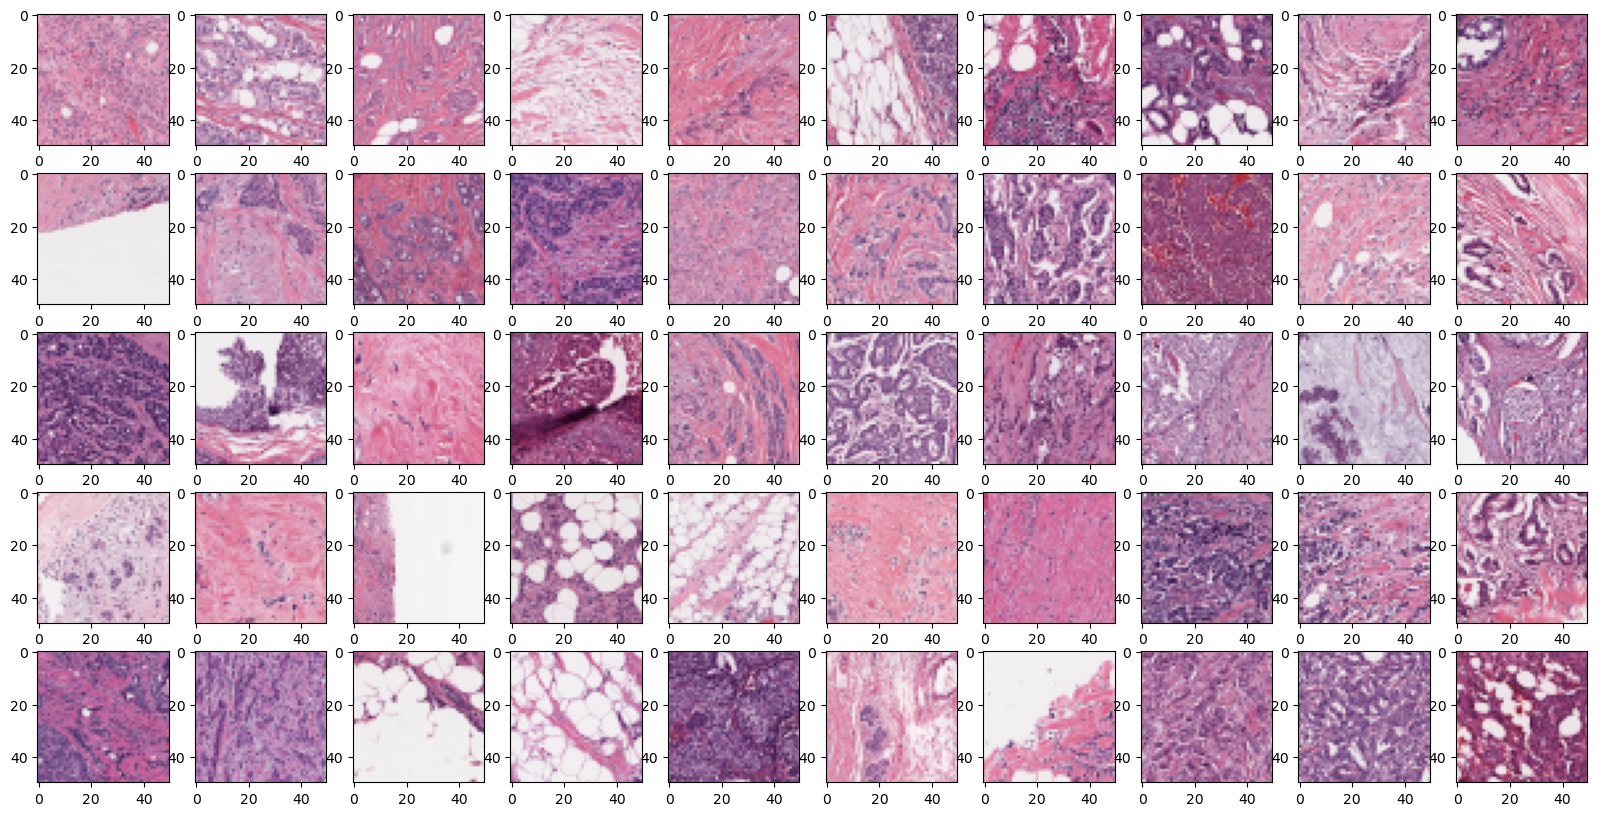

In [9]:
#Cancer Patches
from skimage.io import imread
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

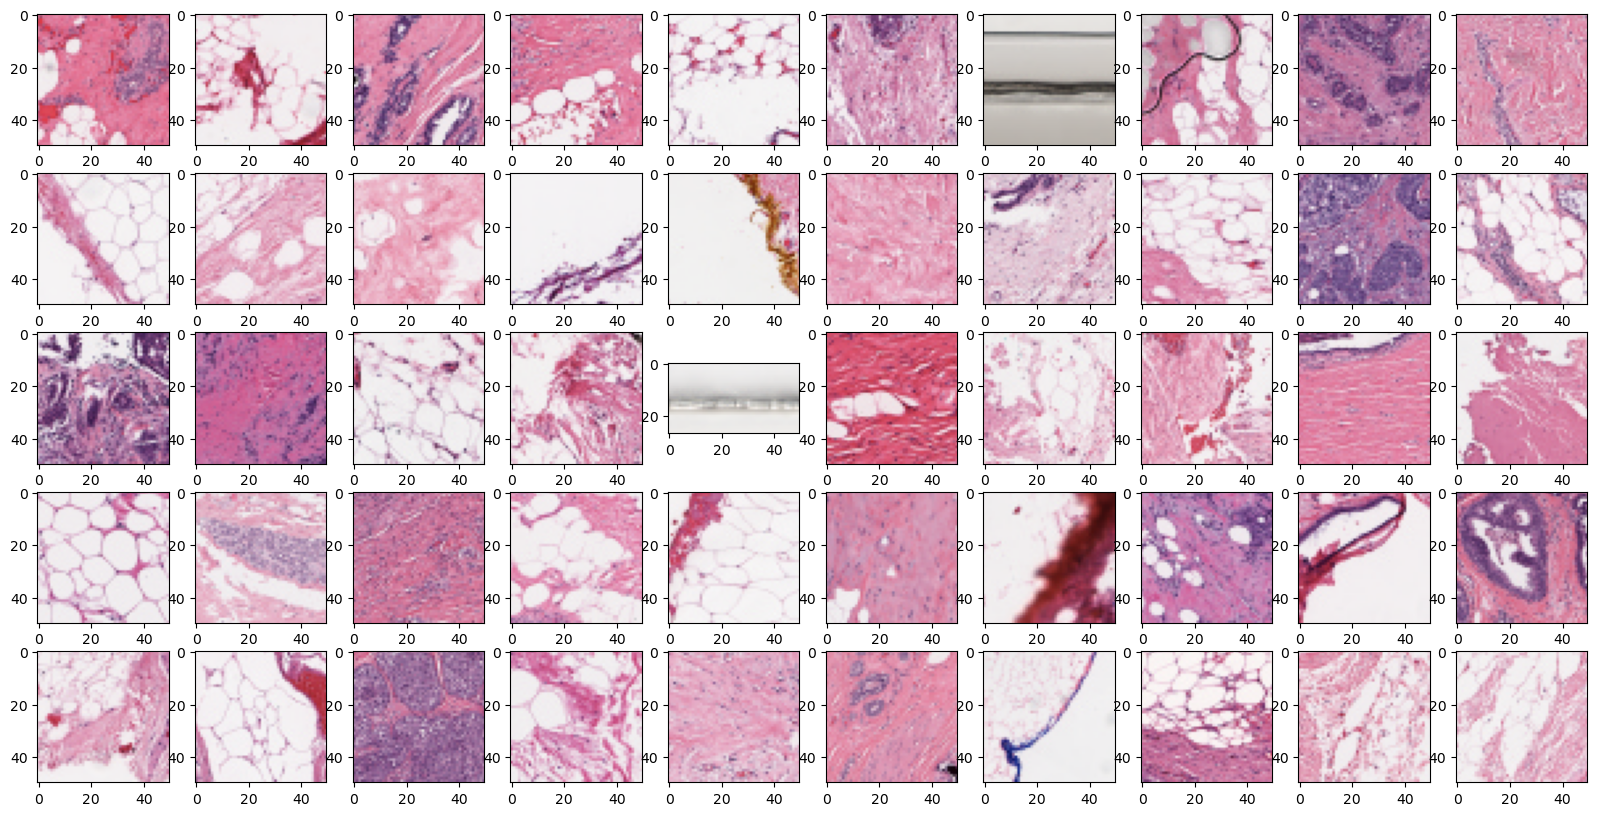

In [10]:
#Healthy Patches
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

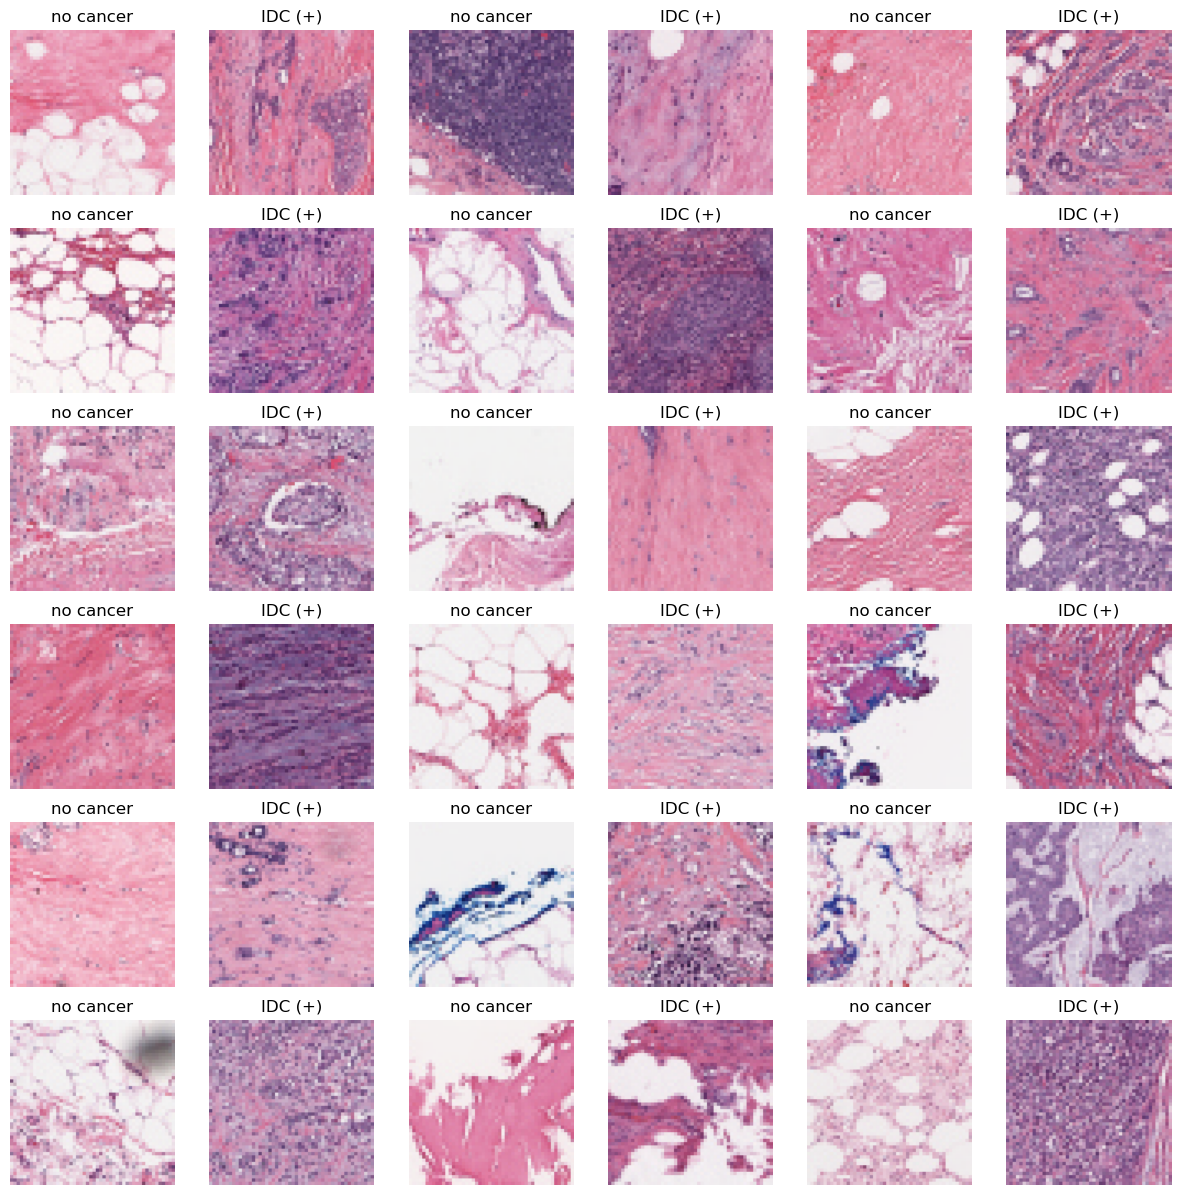

In [11]:
#Combined patches
import tensorflow
import keras
from tensorflow.keras.preprocessing import image
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(non_img), 18)
some_can = np.random.randint(0, len(can_img), 18)

s = 0
for num in some_non:
    
        img = image.load_img((non_img[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
        
s = 1
for num in some_can:
    
        img = image.load_img((can_img[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [12]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [13]:
def visualise_breast_tissue_base(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

In [14]:
def visualise_breast_tissue(patient_id):
    grid, mask, broken_patches,_ = visualise_breast_tissue_base(patient_id)

    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(grid, alpha=0.9)
    ax[1].imshow(mask, alpha=0.8)
    ax[1].imshow(grid, alpha=0.7)
    ax[0].grid(False)
    ax[1].grid(False)
    for m in range(2):
        ax[m].set_xlabel("X-coord")
        ax[m].set_ylabel("Y-coord")
    ax[0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

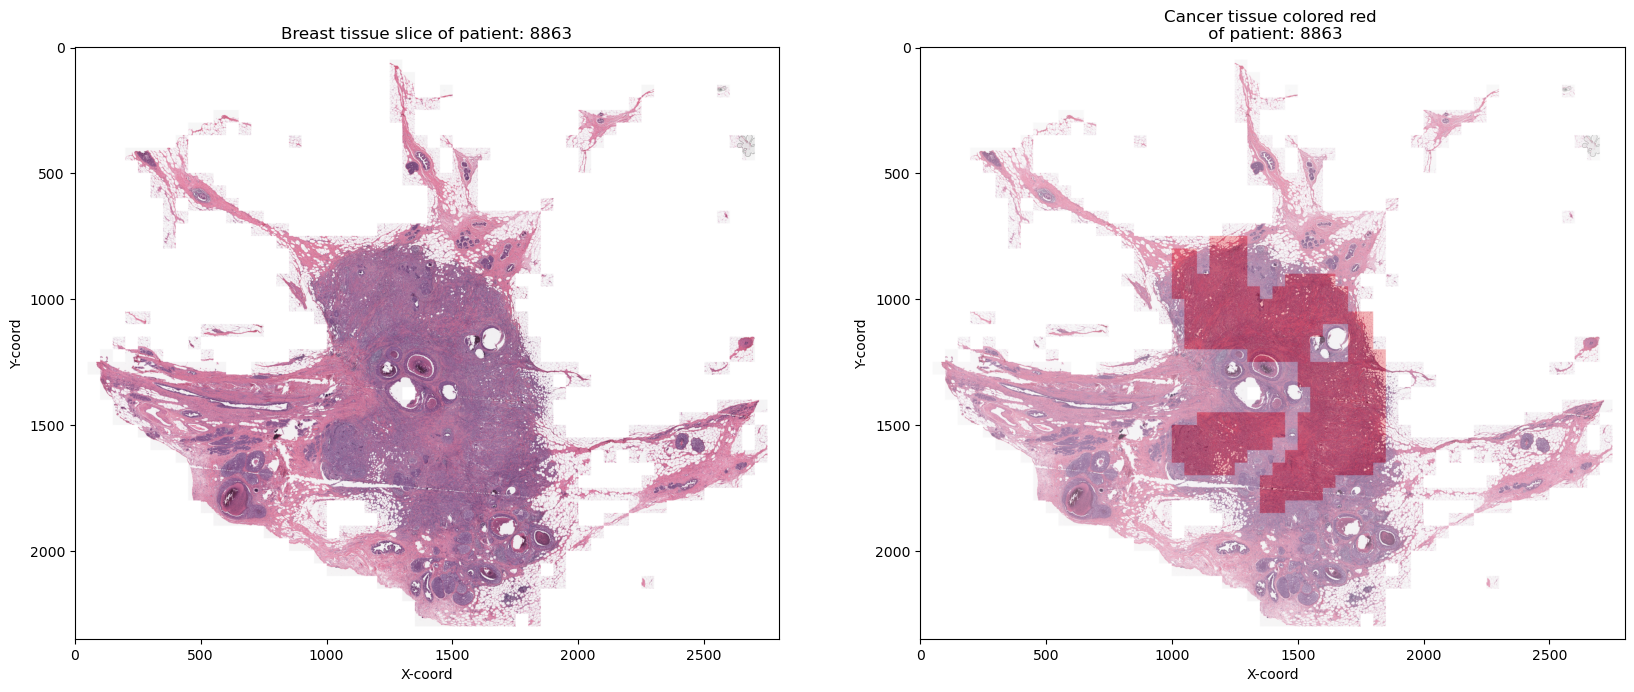

In [15]:
patient_id = "8863"
visualise_breast_tissue(patient_id)

In [16]:
def visualise_breast_tissue_binary(patient_id):
        
    fig, ax = plt.subplots(1,1)

    example_df = get_patient_dataframe(patient_id)

    ax.scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
    ax.set_title("Patient " + patient_id)
    ax.set_xlabel("X coord")
    ax.set_ylabel("Y coord")

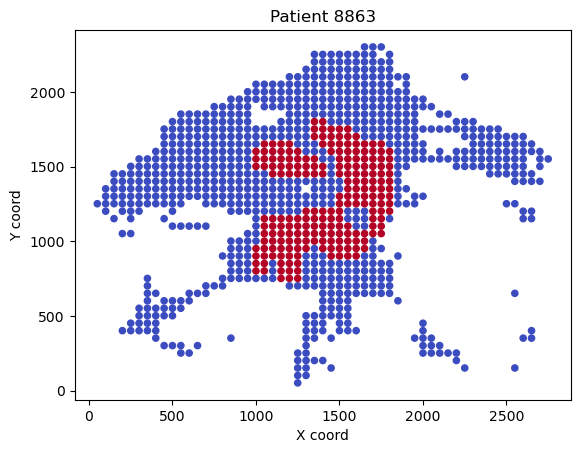

In [17]:
patient_id = "8863"
visualise_breast_tissue_binary(patient_id)

In [18]:
#Data preprocessing

data.head()
data.loc[:, "target"] = data.target.astype(np.str)
data.info()

patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 16.5+ MB


In [19]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

In [20]:
from torch.utils.data import Dataset
class BreastCancerDataset(Dataset):
    
    def __init__(self, df):
        self.states = df
        
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if "target" in self.states.columns.values:
            target = np.int(self.states.target.values[idx])
        else:
            target = None
            
        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [21]:
train_dataset = BreastCancerDataset(train_df)
dev_dataset = BreastCancerDataset(dev_df)
test_dataset = BreastCancerDataset(test_df)

In [22]:
image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

In [23]:
print("Training Dataset : ",dataset_sizes["train"])
print("Dev Dataset : ",dataset_sizes["dev"])
print("Test Dataset : ",dataset_sizes["test"])

Training Dataset :  196069
Dev Dataset :  40395
Test Dataset :  41060


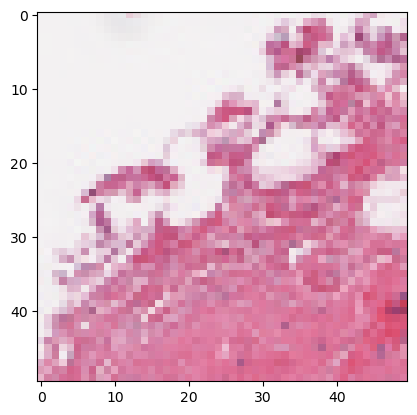

In [24]:
plt.imshow(image_datasets["test"].__getitem__(0)['image'])

In [25]:
#Creating database suitable for tensorflow
train_images = []
train_labels = []
# for i in range(dataset_sizes["train"]):
for i in range(1000):
    train_images.append(np.array(image_datasets["train"].__getitem__(i)['image']))
    train_labels.append(image_datasets["train"].__getitem__(i)['label'])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [26]:
train_images.shape

(1000, 50, 50, 3)

In [27]:
#Creating database suitable for tensorflow
test_images = []
test_labels = []
# for i in range(dataset_sizes["test"]):
for i in range(1000,2000):
    test_images.append(np.array(image_datasets["train"].__getitem__(i)['image']))
    test_labels.append(image_datasets["train"].__getitem__(i)['label'])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [28]:
test_images.shape

(1000, 50, 50, 3)

In [29]:
#Training
# BATCH_SIZE = 32
# NUM_CLASSES = 2

# from tensorflow.keras import datasets, layers, models
train_images, test_images = train_images / 255.0, test_images / 255.0

In [38]:
from matplotlib.image import imread
import cv2

some_non_img = random.sample(non_img, len(can_img))
some_can_img = random.sample(can_img, len(can_img))

non_img_arr = []
can_img_arr = []

for img in some_non_img:
        
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in some_can_img:
    
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [39]:
X = []
y = []

breast_img_arr = np.concatenate((non_img_arr, can_img_arr))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

print('X shape : {}' .format(X.shape))

X shape : (157572, 50, 50, 3)


In [56]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_predict, y_train, y_true = train_test_split(X, y, test_size = 0.3, random_state = 7)

rate = 0.5
num = int(X.shape[0] * rate)

X_test = X_train[num:]
X_train = X_train[:num]

y_test = y_train[num:]
y_train = y_train[:num]

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_true = to_categorical(y_true, 2)

print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('X_predict shape : {}' .format(X_predict.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))
print('y_true shape : {}' .format(y_true.shape))

X_train shape : (78786, 50, 50, 3)
X_test shape : (31514, 50, 50, 3)
X_predict shape : (47272, 50, 50, 3)
y_train shape : (78786, 2)
y_test shape : (31514, 2)
y_true shape : (47272, 2)


In [57]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))

model.add(Dropout(0.5))
model.add(Dense(2, activation = 'sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)       

In [58]:
from keras.optimizers import Adam

Adam = Adam(learning_rate = 0.0001)
model.compile(loss = 'binary_crossentropy', optimizer = Adam, metrics = ['accuracy'])

In [59]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, batch_size = 50)

Epoch 1/30
   1/1576 [..............................] - ETA: 24:18 - loss: 48.8620 - accuracy: 0.5200

2023-03-24 21:20:47.729035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1576/1576 [==============================] - 15s 9ms/step - loss: 0.9596 - accuracy: 0.8346 - val_loss: 0.5535 - val_accuracy: 0.8463
Epoch 2/30
1576/1576 [==============================] - 14s 9ms/step - loss: 0.3566 - accuracy: 0.8529 - val_loss: 0.5232 - val_accuracy: 0.8494
Epoch 3/30
1576/1576 [==============================] - 13s 8ms/step - loss: 0.3282 - accuracy: 0.8590 - val_loss: 0.4622 - val_accuracy: 0.8623
Epoch 4/30
1576/1576 [==============================] - 13s 9ms/step - loss: 0.3122 - accuracy: 0.8674 - val_loss: 0.3746 - val_accuracy: 0.8685
Epoch 5/30
1576/1576 [==============================] - 13s 8ms/step - loss: 0.3021 - accuracy: 0.8761 - val_loss: 0.3304 - val_accuracy: 0.8828
Epoch 6/30
1576/1576 [==============================] - 13s 9ms/step - loss: 0.2926 - accuracy: 0.8806 - val_loss: 0.3473 - val_accuracy: 0.8707
Epoch 7/30
1576/1576 [==============================] - 13s 8ms/step - loss: 0.2883 - accuracy: 0.8829 - val_loss: 0.3161 - val_accuracy: 0.8

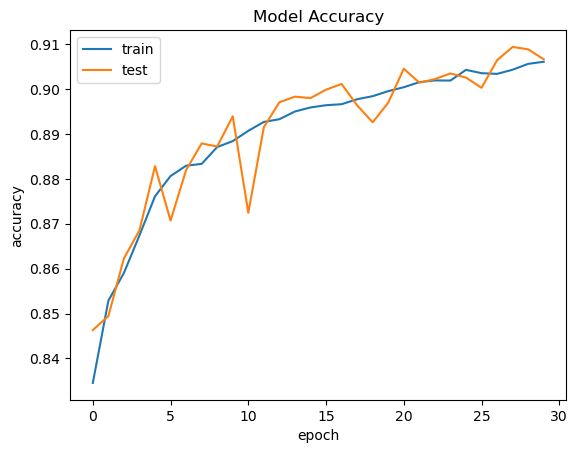

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [61]:
result = model.evaluate(X_test, y_test, batch_size = 50)
print('Test Loss, Test Accuracy :', result)

631/631 [==============================] - 2s 3ms/step - loss: 0.2590 - accuracy: 0.9066
Test Loss, Test Accuracy : [0.2590114176273346, 0.9066129326820374]


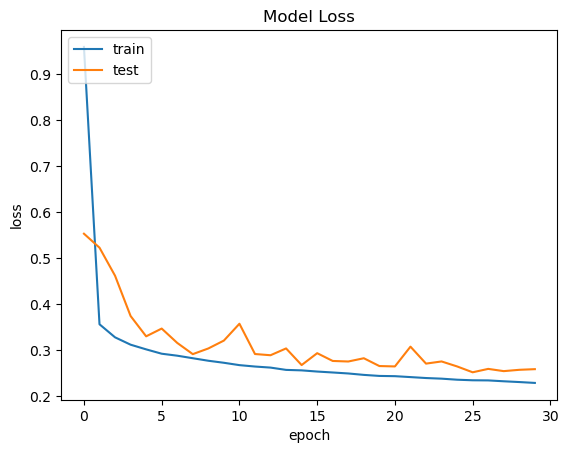

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
P = model.predict(X_predict)

true = 0
for i in range(X_predict.shape[0]):
    if(np.argmax(P[i]) == np.argmax(y_true[i])):
        true = true + 1

pre_accuracy = 100 * float(true/X_predict.shape[0])        
print('Predict Accuracy: {}' .format(pre_accuracy))

1478/1478 [==============================] - 3s 2ms/step
Predict Accuracy: 90.54196987645963


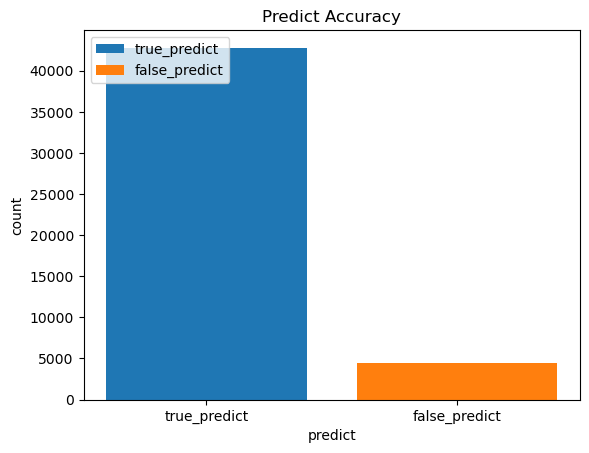

In [66]:
import seaborn as sns
false = len(X_predict) - true

predict = [true, false]
label = ['true_predict', 'false_predict']

plt.bar(label[0], predict[0])
plt.bar(label[1], predict[1])
plt.title('Predict Accuracy')
plt.xlabel('predict')
plt.ylabel('count')
plt.legend(['true_predict', 'false_predict'], loc='upper left')
plt.show()

985/985 [==============================] - 2s 2ms/step


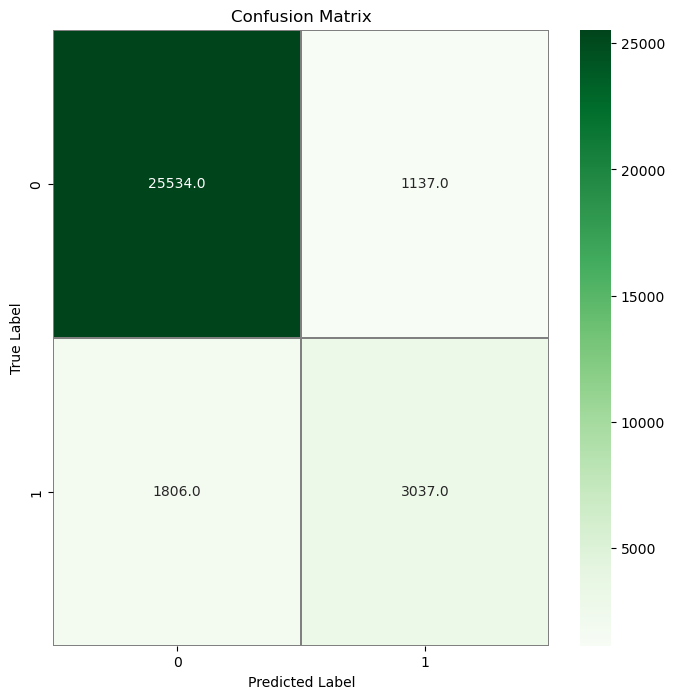

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()